# Dow Jones Data Analysis

Here we analize historical stock prices (2006-2018) for 29 companies on the Down Jones Industrial Average (DJIA):
MMM, 3M
AXP, American Express Company
AAPL, Apple Inc.
BA, Boeing Co.
CTA, Caterpillar Inc.
CVX, Chevron Corp.
etc

For ease of computation, only 2 relevant quantities are considered for each stock: **Opening price** and **Volume**. The first is representative of the price for the stock during the day, while the second reports how 'important' is the stock.

Data was obtained from Kaggle ['DJIA 30 Stock Time Series'](https://www.kaggle.com/datasets/szrlee/stock-time-series-20050101-to-20171231?select=AXP_2006-01-01_to_2018-01-01.csv). This notebook can be accesed uing [this link](https://drive.google.com/file/d/1H0I3sc2IIxzSMIAaLSmUhMocAL8IlyIY/view?usp=sharing).

## Data loading

Data is loaded locally from files downloaded from ['DJIA 30 Stock Time Series'](https://www.kaggle.com/datasets/szrlee/stock-time-series-20050101-to-20171231?select=AXP_2006-01-01_to_2018-01-01.csv).
This data is assumed to have *multiplicative noise*,
$$ \text{Data} = \text{TrueValue} * \text{Noise}_+.$$
This assumption, common in economics, comes from observing that the quantities of interest are positive and they tend grow exponentally. Noise is also assumed to be positive.

Under the assumption of multiplicative noise, the data is log-transformed after loading and then treated 'as usual'. 

In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')
patt = '/content/drive/MyDrive/Work/2022_1_spring/Class/project' #path

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
stocks = ['MMM', 'AXP', 'AAPL', 'BA', 'CAT', 'CVX', 'CSCO', 'KO', 'DIS', 'XOM', 
          'GE','GS', 'HD', 'IBM', 'INTC', 'JNJ', 'JPM', 'MCD', 'MRK', 'MSFT', 
          'NKE', 'PFE', 'PG', 'TRV', 'UTX', 'UNH', 'VZ', 'WMT', 'GOOGL', 
          'AMZN']#, 'AABA'

In [4]:
start = datetime.datetime(2006, 1, 1)
end   = datetime.datetime(2018, 1, 1)
start_date_str = str(start.date())
end_date_str   = str(end.date())

In [99]:
all_stocks = 0 # reinitialization for re-runs
for (i, ticker) in enumerate(stocks):
  file_name = patt + '/stocks/' + ticker + '_' + start_date_str + '_to_' + end_date_str + '.csv'
  data = pd.read_csv(file_name, parse_dates=['Date'], index_col=['Date'])
  lab1 = ticker+'_opn'
  lab2 = ticker+'_vol'
  data = data.rename(columns={'Open': lab1, 'Volume': lab2})
  #data[lab2] = np.log(data[lab2])
  if i==0:
    all_stocks = np.log(data[[lab1, lab2]])
    opn_all    = [lab1]
    vol_all    = [lab2]
  else:
    all_stocks[[lab1,lab2]] = np.log(data[[lab1, lab2]])
    opn_all.append( lab1 )
    vol_all.append( lab2 )
all_stocks = all_stocks.dropna()
all_stocks = all_stocks.astype('float64')

Representative plot with prices and volumes from 3M, American Express and Apple Inc.

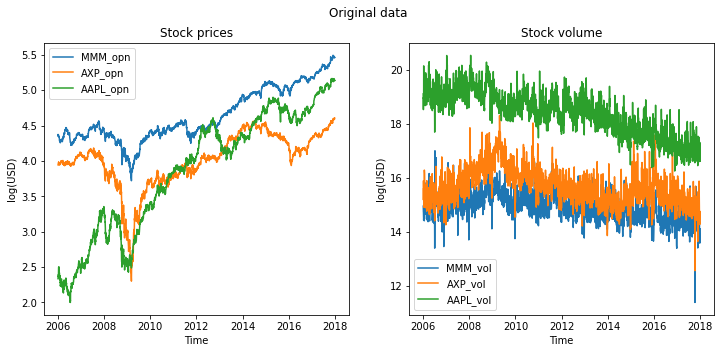

In [101]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(12,5))
fig.suptitle('Original data')
for i in range(3):
  ax[0].plot(all_stocks[opn_all[i]],label=opn_all[i])
  ax[1].plot((all_stocks[vol_all[i]]),label=vol_all[i])
ax[0].set_title('Stock prices')
ax[1].set_title('Stock volume')

for axi in fig.get_axes():
  axi.set(xlabel='Time')
  axi.set(ylabel='log(USD)')

ax[0].legend(loc="upper left")
ax[1].legend(loc="lower left")
fig.show()

## Pre-processing

Data is normalized to have zero median and unit median error; this condition replaces zero mean and unit variance for robustness and snobbery. 

Fast oscillations are removed from data by using a low-pass Butterworth filter with a bandwidth equivalent to 1 month.

In [102]:
MED1 = [] #vector of medians
MED2 = [] #vector of mean absolute error
for i in all_stocks.columns:
  med1 = np.median( all_stocks[i] )
  MED1.append(med1)
  all_stocks[i] = all_stocks[i]-med1
  med2 = np.median(abs( all_stocks[i] ))
  all_stocks[i] = all_stocks[i]/med2
  MED2.append(med2)

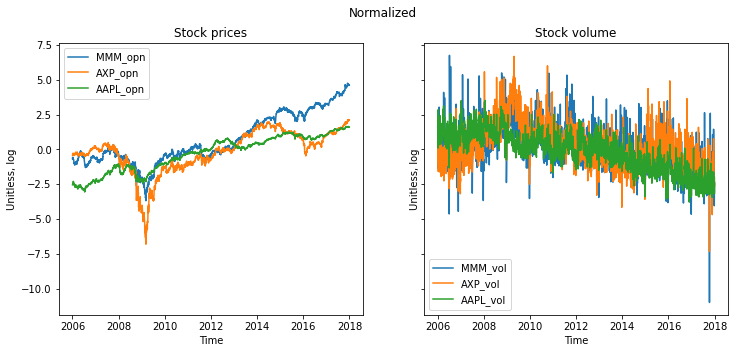

In [103]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12,5))
fig.suptitle('Normalized')
for i in range(3):
  ax[0].plot(all_stocks[opn_all[i]],label=opn_all[i])
  ax[1].plot((all_stocks[vol_all[i]]),label=vol_all[i])
ax[0].set_title('Stock prices')
ax[1].set_title('Stock volume')

for axi in fig.get_axes():
  axi.set(xlabel='Time')
  axi.set(ylabel='Unitless, log')

ax[0].legend(loc="upper left")
ax[1].legend(loc="lower left")
fig.show()

In [104]:
from scipy.signal import butter,filtfilt# Filter requirements.

def butter_lowpass(data, cutoff, fs, order):
  nyq = 365/2 
  normal_cutoff = cutoff / nyq
  # Get the filter coefficients 
  b, a = butter(order, normal_cutoff, btype='low', analog=False)
  y = filtfilt(b, a, data)
  return y
def butter_highpass(data, cutoff, fs, order):
  nyq = 365/2 
  normal_cutoff = cutoff / nyq
  # Get the filter coefficients 
  b, a = butter(order, normal_cutoff, btype='high', analog=False)
  y = filtfilt(b, a, data)
  return y

In [105]:
all_stocks_filtered = all_stocks.copy()
for i in all_stocks.columns:
  all_stocks_filtered[i] = butter_lowpass(all_stocks[i], 12, 365, 4)

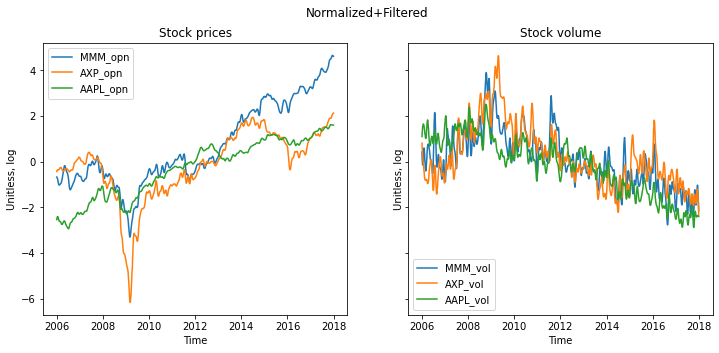

In [106]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12,5))
fig.suptitle('Normalized+Filtered')
for i in range(3):
  ax[0].plot(all_stocks_filtered[opn_all[i]],label=opn_all[i])
  ax[1].plot((all_stocks_filtered[vol_all[i]]),label=vol_all[i])
ax[0].set_title('Stock prices')
ax[1].set_title('Stock volume')

for axi in fig.get_axes():
  axi.set(xlabel='Time')
  axi.set(ylabel='Unitless, log')

ax[0].legend(loc="upper left")
ax[1].legend(loc="lower left")
fig.show()

For ease of coding, the filtered data is used as a default. The original data is also kept, additionally to the data without the 'Date' column.

In [107]:
data  = all_stocks_filtered
dataO = all_stocks
dataP = data.copy() # data with 'picky' formatting
dataP = dataP.dropna()
dataP = dataP.reset_index() 
dataP = dataP.drop(columns='Date')
dataP = dataP.astype('float64')
dat   = data.reset_index()['Date']

To measure the quality of this filtered data, consider the joint histogram for residuals. 

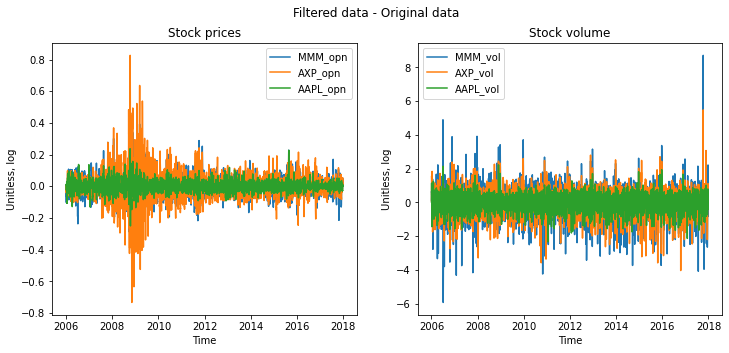

In [112]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(12,5))
fig.suptitle('Filtered data - Original data')
for i in range(3):
  ax[0].plot(data[opn_all[i]]-dataO[opn_all[i]],label=opn_all[i])
  ax[1].plot((data[vol_all[i]]-dataO[vol_all[i]]),label=vol_all[i])
ax[0].set_title('Stock prices')
ax[1].set_title('Stock volume')

for axi in fig.get_axes():
  axi.set(xlabel='Time')
  axi.set(ylabel='Unitless, log')

ax[0].legend(loc="upper right")
ax[1].legend(loc="upper left")
fig.show()

## Analysis with DMD

### Construction of the model

In [17]:
%%capture
!pip install pydmd

In [18]:
from pydmd import DMD

The number of modes, $n$, will be determined by the first $n$ singular values that 'explain' 85% of the variance.

28 modes should be used.


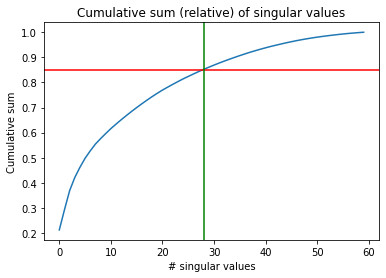

In [129]:
import scipy as sp
svals = sp.linalg.svdvals(dataP)
curr  = 0
for i in range(len(svals)):
  curr = curr + svals[i]/sum(svals)
  if curr>=.85:
    n = i
    print(f'{n} modes should be used.')
    break
plt.plot(np.cumsum(svals)/sum(svals))
plt.axhline(y=0.85, color='r', linestyle='-')
plt.axvline(x=n, color='g', linestyle='-')
plt.title('Cumulative sum (relative) of singular values')
plt.xlabel('# singular values')
plt.ylabel('Cumulative sum')
plt.show()

In [130]:
model = DMD(svd_rank=n)
model.fit(dataP.to_numpy().T)

### Analysis of the model

For further inspection of the DMD model, the following objects are plotted:
1.   Eigenvalues.
2.   Modes.
3. Dynamics



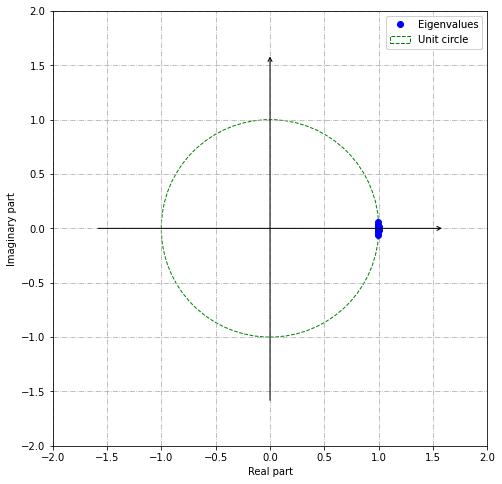

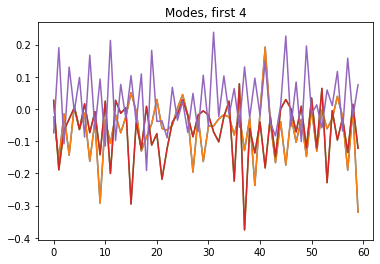

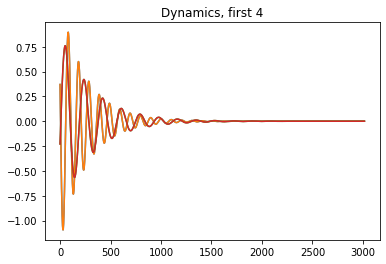

In [131]:
model.plot_eigs(show_axes=True, show_unit_circle=True)
for i in range(5):
  mode = model.modes.T.real[i]
  plt.plot(mode)
plt.title('Modes, first 4')
plt.show()
for i in range(4):
  dynamic = model.dynamics[i]
  plt.plot(dynamic.real)
plt.title('Dynamics, first 4')
plt.show()

From the previous plots we find that the model is uncondinionally stable: all variables on the model will converge to zero.

The fact that all eigenvalues are close to 1 indicates that the model is dependent on **all** the modes. Many of those modes doesn't have a meaningful interpretation.

### Data prediction

Using the DMD model, first the original data is reconstructed and then 2 years of data are predicted.

In [132]:
# for fancy labelling
d_lab = pd. date_range(start="2006-01-01",end="2020-01-01"). to_pydatetime(). tolist()
n_pts = len(d_lab)
last  = data.reset_index()['Date'] # last point on dataset
last  = last[len(last)-1]
model.dmd_time['tend'] = n_pts-1

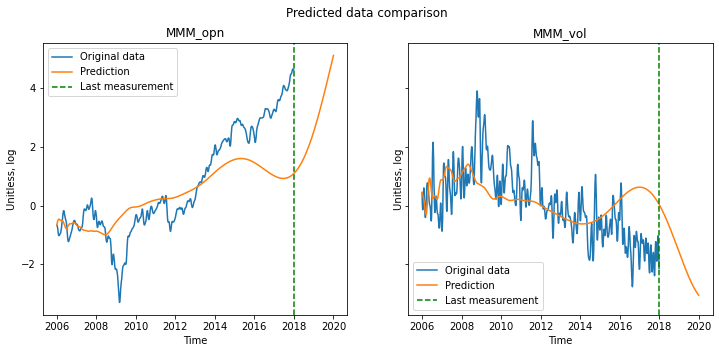

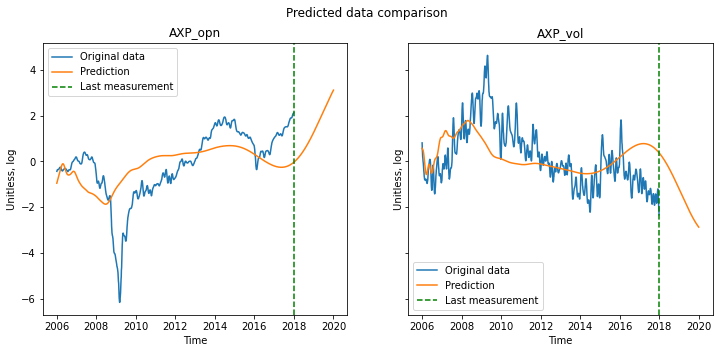

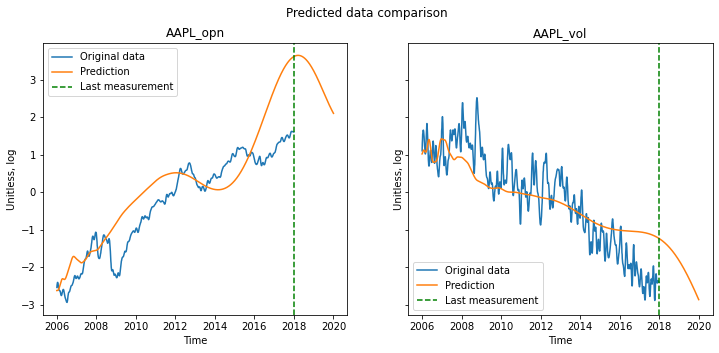

In [133]:
for i in range(3):
  fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12,5))
  fig.suptitle('Predicted data comparison')
  j = 2*i
  ax[0].set_title(data.columns[j])
  ax[1].set_title(data.columns[j+1])

  for k in range(2):
    ax[k].plot(data.reset_index()['Date'],data.to_numpy().T[j+k],label='Original data')
    ax[k].plot(d_lab,model.reconstructed_data[j+k].T.real,label='Prediction')
    ax[k].axvline(x=last, color='g', linestyle='--',label='Last measurement')
    ax[k].set(xlabel='Time')
    ax[k].set(ylabel='Unitless, log')

  ax[0].legend(loc="upper left")
  ax[1].legend(loc="lower left")
  fig.show()